In [410]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import time
from pathlib import Path
import json
import re

# import tqdm
import matplotlib.pyplot as plt

In [411]:
batch_size = 128
num_epochs = 5
context_len = 64
initial_lr = 0.001
data_path = "./data/chinese-poetry/唐诗"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("now using", device)

now using cuda


## Self-Attention


In [412]:
x = torch.rand(1, 3, 5)
print(x)
raw_weights = torch.bmm(x, x.transpose(1, 2))
print(raw_weights)
weights = F.softmax(raw_weights, dim=2)
print(weights)
y = torch.bmm(weights, x)
print(y)

tensor([[[0.3679, 0.1592, 0.5094, 0.8947, 0.7041],
         [0.8402, 0.8056, 0.0906, 0.2361, 0.8409],
         [0.3965, 0.6249, 0.1565, 0.2882, 0.9541]]])
tensor([[[1.7165, 1.2867, 1.2547],
         [1.2867, 2.1260, 1.7211],
         [1.2547, 1.7211, 1.5656]]])
tensor([[[0.4384, 0.2853, 0.2763],
         [0.2058, 0.4764, 0.3178],
         [0.2526, 0.4027, 0.3447]]])
tensor([[[0.5105, 0.4723, 0.2924, 0.5393, 0.8122],
         [0.6020, 0.6152, 0.1977, 0.3882, 0.8487],
         [0.5680, 0.5801, 0.2191, 0.4204, 0.8453]]])


In [413]:
# converter = opencc.OpenCC("t2s")


def sentenceParse(para):
    para = re.sub(r"（.*?）", "", para)
    para = re.sub(r"\(.*?\)", "", para)
    para = re.sub(r"{.*?}", "", para)
    para = re.sub(r"《.*?》", "", para)
    para = re.sub(r"[\[\]]", "", para)
    para = "".join([s for s in para if s not in "0123456789-"])
    para = re.sub(r"。。", "。", para)
    para = re.sub(r"？。", "。", para)
    para = re.sub(r"？", "。", para)
    # para = converter.convert(para)
    if "𫗋" in para or len(para) > context_len or len(para) < 24:
        return ""
    return para


def parseRawData(author=None, constrain=None):
    def handleJson(file_path):
        with open(file_path, "r", encoding="utf-8") as file:
            data = json.load(file)
        rst = []
        for poetry in data:
            if author and poetry.get("author") != author:
                continue

            # paragraphs = poetry.get("paragraphs")
            paragraphs = poetry.get("content")

            if any(
                len(tr) != constrain and len(tr) != 0
                for s in paragraphs
                for tr in re.split("[，！。]", s)
                if constrain is not None
            ):
                continue

            pdata = "".join(paragraphs)
            pdata = sentenceParse(pdata)
            segments = [segment for segment in re.split(r"[，。]", pdata) if segment]

            # 仅训练五言绝句和七言律诗
            if any(len(segment) not in [5, 7] for segment in segments):
                continue
            # 去除含有错误字符的诗句
            if '□' in pdata:
                continue
            if pdata:
                rst.append(pdata)
        return rst

    poems = []
    src_path = Path(data_path)
    for file_path in src_path.glob("data3*"):
        poems.extend(handleJson(file_path))
    return poems


poems = parseRawData()
poems = set(poems)
poems = list(poems)

In [414]:
# 构建词汇表
word_to_index = {}
for poem in poems:
    for word in poem:
        if word not in word_to_index:
            word_to_index[word] = len(word_to_index)
word_to_index["<EOP>"] = len(word_to_index)  # End Of Poem token
word_to_index["<START>"] = len(word_to_index)  # Start token
index_to_word = {index: word for word, index in word_to_index.items()}

vocab_size = len(word_to_index)

print("VOCAB_SIZE:", vocab_size)
print("data_size", len(poems))


# 将句子转换为列表形式，并添加结束符
def sentence_to_list(sentence):
    return list(sentence) + ["<EOP>"]


poems = [sentence_to_list(poem) for poem in poems]


# 创建单词索引张量
def create_index_tensor(word, word_to_index):
    return torch.LongTensor([word_to_index[word]])


# 创建真正的 one-hot 编码向量
def create_one_hot_vector(word, word_to_index, vocab_size):
    vector = torch.zeros(vocab_size)
    vector[word_to_index[word]] = 1
    return vector


index_tensors = {
    word: create_index_tensor(word, word_to_index) for word in word_to_index
}

# 如果需要，可以这样创建 one-hot 编码向量
# one_hot_vectors = {
#     word: create_one_hot_vector(word, word_to_index, vocab_size) for word in word_to_index
# }

VOCAB_SIZE: 6938
data_size 40678


In [415]:
def generate_sample(sequence):

    inputs = [index_tensors[sequence[i - 1]] for i in range(1, len(sequence))]
    outputs = [index_tensors[sequence[i]] for i in range(1, len(sequence))]

    # 将输入和输出列表合并为张量
    encoded_inputs = torch.cat(inputs)
    encoded_outputs = torch.cat(outputs)

    return encoded_inputs, encoded_outputs


# generate_sample(poems[0], one_hot_vectors)


class PoetryDataset(Dataset):
    def __init__(self, poems, transform=None):
        self.poems = poems
        self.transform = transform

    def __len__(self):
        return len(self.poems)

    def __getitem__(self, index):
        poem = self.poems[index]
        input_data, output_data = generate_sample(poem)
        if self.transform:
            input_data = self.transform(input_data)
        return input_data, output_data


def custom_collate_fn(batch):
    sequences, targets = zip(*batch)
    # 统一长度以进行批处理
    padded_sequences = nn.utils.rnn.pad_sequence(
        sequences, batch_first=True, padding_value=word_to_index["<START>"]
    )
    padded_targets = nn.utils.rnn.pad_sequence(
        targets, batch_first=True, padding_value=word_to_index["<START>"]
    )
    return padded_sequences, padded_targets


dataset = PoetryDataset(poems)
data_loader = DataLoader(
    dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn
)

![](../multi-head.png)

![](../self-attention.png)


In [416]:
class SelfAttention(nn.Module):
    def __init__(self, embed_size, num_heads=4, mask=False):
        super(SelfAttention, self).__init__()

        assert embed_size % num_heads == 0, "Embedding size 必须是 heads 的整数倍"
        self.embed_size = embed_size
        self.num_heads = num_heads
        self.head_dim = embed_size // num_heads

        # 计算所有 heads 的 query, key 和 value
        self.query_projection = nn.Linear(embed_size, embed_size, bias=False)
        self.key_projection = nn.Linear(embed_size, embed_size, bias=False)
        self.value_projection = nn.Linear(embed_size, embed_size, bias=False)

        # 在 multi-head self-attention 操作后应用
        self.fc_out = nn.Linear(embed_size, embed_size)
        self.mask = mask

    def forward(self, x):
        batch_size, seq_length, embed_size = x.size()

        # 计算所有 heads 的 query, key 和 value
        queries = self.query_projection(x).view(
            batch_size, seq_length, self.num_heads, self.head_dim
        )
        keys = self.key_projection(x).view(
            batch_size, seq_length, self.num_heads, self.head_dim
        )
        values = self.value_projection(x).view(
            batch_size, seq_length, self.num_heads, self.head_dim
        )

        # 将 tensor 重新排列，以适应 multi-head attention
        queries = (
            queries.transpose(1, 2)
            .contiguous()
            .view(batch_size * self.num_heads, seq_length, self.head_dim)
        )
        keys = (
            keys.transpose(1, 2)
            .contiguous()
            .view(batch_size * self.num_heads, seq_length, self.head_dim)
        )
        values = (
            values.transpose(1, 2)
            .contiguous()
            .view(batch_size * self.num_heads, seq_length, self.head_dim)
        )

        # 计算 Scaled dot-product attention
        dot_product = torch.bmm(queries, keys.transpose(1, 2))
        scaled_dot_product = dot_product / (self.embed_size**0.5)

        # 如果启用了 mask，则对未来的 token 进行屏蔽
        if self.mask:
            mask = torch.triu(torch.ones(seq_length, seq_length), diagonal=1).bool()
            mask = mask.to(device)
            scaled_dot_product.masked_fill_(mask, float("-inf"))

        attention = F.softmax(scaled_dot_product, dim=2)

        # 将 self-attention 应用于 values
        out = torch.bmm(attention, values).view(
            batch_size, self.num_heads, seq_length, self.head_dim
        )
        out = (
            out.transpose(1, 2)
            .contiguous()
            .view(batch_size, seq_length, self.embed_size)
        )

        return self.fc_out(out)

![](../transformer-architecture.png)


In [417]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, num_heads, mask=False):
        super(TransformerBlock, self).__init__()

        self.attention = SelfAttention(embed_size, num_heads=num_heads, mask=mask)
        self.norm1 = nn.LayerNorm(embed_size)
        self.ff = nn.Sequential(
            nn.Linear(embed_size, 4 * embed_size),
            nn.ReLU(),
            nn.Linear(4 * embed_size, embed_size),
        )
        self.norm2 = nn.LayerNorm(embed_size)

    def forward(self, x):
        # Self-attention 和残差连接
        attended = self.attention(x)
        x = self.norm1(attended + x)

        # 前馈神经网络和残差连接
        fedforward = self.ff(x)
        return self.norm2(fedforward + x)

In [418]:
class Transformer(nn.Module):
    def __init__(
        self,
        embed_size,
        num_heads,
        num_layers,
        seq_length,
        num_tokens,
        num_classes,
        mask=False,
    ):
        super(Transformer, self).__init__()

        self.token_emb = nn.Embedding(num_tokens, embed_size)
        self.pos_emb = nn.Embedding(seq_length, embed_size)

        self.layers = nn.ModuleList(
            [TransformerBlock(embed_size, num_heads, mask) for _ in range(num_layers)]
        )

        self.fc_out = nn.Linear(embed_size, num_classes)

    def forward(self, x):
        """
        :param x: A (batch_size, seq_length) tensor of integer values representing words (in some predetermined vocabulary).
        :return: A (batch_size, num_classes) tensor of log-probabilities over the classes.
        """
        batch_size, seq_length = x.size()

        # 生成 token 嵌入
        tokens = self.token_emb(x)

        # 生成位置嵌入
        positions = torch.arange(seq_length).to(x.device)
        positions = self.pos_emb(positions).expand(batch_size, seq_length, -1)

        # 将 token 嵌入和位置嵌入相加
        x = tokens + positions

        # 通过所有 Transformer 层
        for layer in self.layers:
            x = layer(x)

        # 最后映射到类概率
        x = self.fc_out(x)

        return x

In [419]:
mask = True
model = Transformer(
    embed_size=256,
    num_heads=4,
    num_layers=8,
    seq_length=128,
    num_tokens=vocab_size,
    num_classes=vocab_size,
    mask=True,
)

optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=9, verbose=True
)
criterion = nn.CrossEntropyLoss(ignore_index=word_to_index["<START>"])

In [420]:
def train(model, data_loader, num_epochs, device, optimizer, criterion, scheduler):
    log_dict = {
        "train_loss_per_epoch": [],
        "train_perplexity_per_epoch": [],
    }
    start_time = time.time()
    model = model.to(device)
    for epoch in range(num_epochs):
        current_lr = optimizer.param_groups[0]["lr"]
        print(
            f"Epoch: {epoch+1:03d}/{num_epochs:03d} | Current Learning Rate: {current_lr:.6f}"
        )
        total_loss = 0
        model.train()
        for batch_idx, (inputs, targets) in enumerate(data_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * inputs.size(0)

            if not batch_idx % 100:
                print(
                    f"Epoch: {epoch + 1:03d}/{num_epochs:03d} | Batch {batch_idx:04d}/{len(data_loader):04d} | Loss: {loss:.6f}"
                )
        torch.save(model, "model.pth")

        avg_loss = total_loss / len(data_loader.dataset)
        scheduler.step(avg_loss)
        perplexity = torch.exp(torch.tensor(avg_loss))
        log_dict["train_loss_per_epoch"].append(avg_loss)
        log_dict["train_perplexity_per_epoch"].append(perplexity)

        print(f"Time elapsed: {(time.time() - start_time) / 60:.2f} min")

    print(f"Total Training Time: {(time.time() - start_time)/ 60:.2f} min")
    return log_dict

In [421]:
log_dict = train(
    model, data_loader, num_epochs, device, optimizer, criterion, scheduler
)
# model = torch.load("model-full.pth")

Epoch: 001/005 | Current Learning Rate: 0.001000
Epoch: 001/005 | Batch 0000/0318 | Loss: 8.998508
Epoch: 001/005 | Batch 0100/0318 | Loss: 5.766684
Epoch: 001/005 | Batch 0200/0318 | Loss: 5.445594
Epoch: 001/005 | Batch 0300/0318 | Loss: 5.243609
Time elapsed: 0.88 min
Epoch: 002/005 | Current Learning Rate: 0.001000
Epoch: 002/005 | Batch 0000/0318 | Loss: 5.198214
Epoch: 002/005 | Batch 0100/0318 | Loss: 5.068654
Epoch: 002/005 | Batch 0200/0318 | Loss: 5.037173
Epoch: 002/005 | Batch 0300/0318 | Loss: 4.853765
Time elapsed: 1.78 min
Epoch: 003/005 | Current Learning Rate: 0.001000
Epoch: 003/005 | Batch 0000/0318 | Loss: 4.866686
Epoch: 003/005 | Batch 0100/0318 | Loss: 4.951128
Epoch: 003/005 | Batch 0200/0318 | Loss: 4.898198
Epoch: 003/005 | Batch 0300/0318 | Loss: 4.833848
Time elapsed: 2.67 min
Epoch: 004/005 | Current Learning Rate: 0.001000
Epoch: 004/005 | Batch 0000/0318 | Loss: 4.817050
Epoch: 004/005 | Batch 0100/0318 | Loss: 4.835166
Epoch: 004/005 | Batch 0200/0318 | 

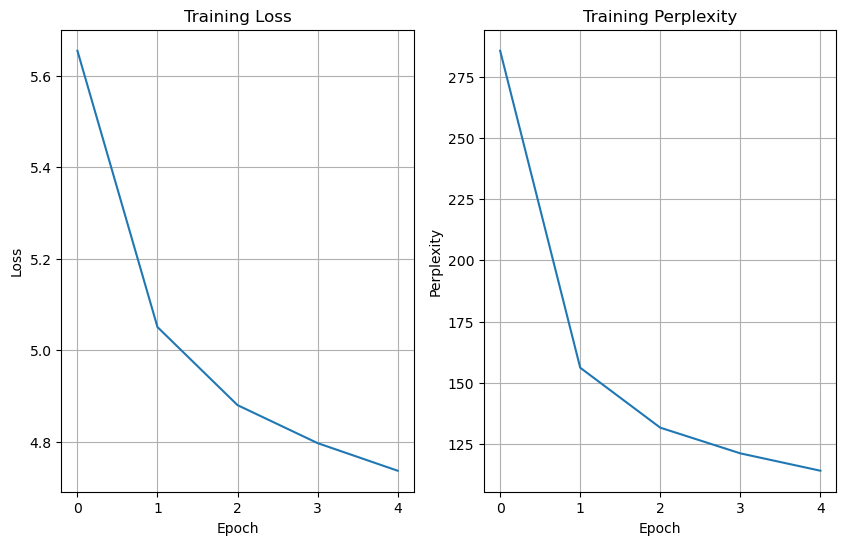

In [422]:
def plot_training_stats(log_dict):
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.plot(log_dict["train_loss_per_epoch"], label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(log_dict["train_perplexity_per_epoch"], label="Training Perplexity")
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.grid(True)
    # plt.yscale("log")
    plt.title("Training Perplexity")
    plt.savefig("training_stats.svg")
    plt.show()


plot_training_stats(log_dict)

In [467]:
def generate_text(start_word="<START>", top_k=1, temperature=0.7, log=False):
    generated_text = ""
    words = []
    for word in start_word:
        words += [word]
    # print(words)
    model.eval()
    with torch.no_grad():
        index_tensors_list = []
        for word in words:
            index_tensors_list.append(
                torch.LongTensor([word_to_index[word]]).unsqueeze(0)
            )
            generated_text += word

        input_tensor = torch.cat(index_tensors_list, dim=1)
        for _ in range(context_len - len(generated_text)):

            output = model(input_tensor.to(device))

            last_word = output[:, -1, :]
            last_word = last_word.view(-1)

            # 调整温度
            # softmax 函数倾向于增强输入向量中最大值的影响
            scaled_logits = last_word / temperature
            probabilities = F.softmax(scaled_logits, dim=-1)

            probabilities, top_indices = probabilities.data.topk(top_k)
            top_words = [index_to_word[index.item()] for index in top_indices]
            probabilities = probabilities / torch.sum(probabilities)

            probabilities_np = probabilities.cpu().detach().numpy()
            indices_np = top_indices.cpu().detach().numpy()
            if log:
                for word, prob in zip(top_words, probabilities_np):
                    print(f"{word}: {prob:.4f}")

            selected_index = np.random.choice(indices_np, p=probabilities_np)

            next_word = index_to_word[selected_index]
            if next_word == "<EOP>":
                break
            generated_text += next_word
            if log:
                print(generated_text)
            # * 需要升一个维, 因为模型的输入以 batch 为单位
            input_tensor = torch.cat(
                [input_tensor, torch.LongTensor([selected_index]).unsqueeze(0)], dim=1
            )

    return generated_text.strip()

print(generate_text("故人西辞黄鹤楼", top_k=5, temperature=1.1))
print(generate_text("长", top_k=1))
for i in range(10):
    print(generate_text("月", top_k=9, temperature=1.2))
for i in range(10):
    print(generate_text("海", top_k=3))
print(generate_text("风", top_k=3, log=True))

故人西辞黄鹤楼，江边城上白云中。不堪不见君王粲，何处无情何所思。
长安一夜月，一夜夜深山。夜夜无人去，秋风吹落花。
月满山中有雪峰，风光一曲如无尘。何时已去一人迹，却似春云不肯归。
月明金缕玉，香车吹不回。一夜吹箫管，春风不自流。
月影秋风吹玉声，月光如练夜无端。一生白日一灯影，一夜空庭不可惊。
月落江南风，春城望水深。风情无客恨，愁杀一枝枝。
月夜江头风，春风吹夜深。一枝如一叶，秋露滴残秋。白发花时好，风吹鸟道心。
月明秋草色，寒草自萧条。水色连山色，清波流水声。寒云连海外，寒树月明时。此去无心地，相思有梦多。
月色深山路，秋风入夜凉。一灯一夜夜，江月照寒泉。雨滴秋空远，寒云断鸟鸣。此身未不极，不是不成灰。
月夜江上月不归，一声何事亦不还。不堪愁杀人自在，何事何如一寸心。
月影临寒暑，山中月不归。秋天一叶下，日色夜声寒。
月满秋风急，秋风日暮秋。一时不相望，何况复如君。
海上东流水，春风吹不归。江南望乡客，不见故人愁。
海内无心地，无心不自无。一身无所以，不是一生心。
海内东西路，东风日日新。一时一夜月，春色入山中。
海上无心不可怜，一枝无事不堪悲。一枝一夜无人事，不觉无心亦自由。
海上青山路不平，一年无事更堪愁。不能别后无人事，不是无人不可寻。
海内东流水，江南望故乡。江边山上路，江上望乡人。
海内东风吹，东流入帝乡。风吹山色尽，山水落花开。
海上无人道，无人不可怜。不知无一事，何处不堪愁。
海上无尘土，无人不可论。今朝无所以，何处不相亲。
海上无人事，何时不可怜。
吹: 0.5453
光: 0.2575
雨: 0.1972
风吹
一: 0.4106
不: 0.3489
春: 0.2405
风吹一
夜: 0.5389
枝: 0.2919
叶: 0.1692
风吹一夜
月: 0.4034
夜: 0.3418
雨: 0.2549
风吹一夜雨
，: 0.9924
声: 0.0046
初: 0.0030
风吹一夜雨，
秋: 0.4159
春: 0.2963
风: 0.2878
风吹一夜雨，秋
风: 0.7113
色: 0.1700
草: 0.1188
风吹一夜雨，秋风
吹: 0.7408
满: 0.1374
不: 0.1219
风吹一夜雨，秋风吹
落: 0.3766
不: 0.3193
夜: 0.3041
风吹一夜雨，秋风吹不
归: 0.4845
回: 0.3097
还

In [574]:
def generate_acrostic(start_word="<START>", top_k=1, temperature=0.7, log=False):
    generated_text = ""
    words = []
    for word in start_word:
        words += [word]
    # print(words)
    model.eval()
    with torch.no_grad():
        index_tensors_list = []
        # for word in words:
        index_tensors_list.append(
                torch.LongTensor([word_to_index[words[0]]]).unsqueeze(0)
            )

        generated_text += words[0]
        ind = 1

        for _ in range(context_len - len(generated_text)):
            input = torch.tensor(index_tensors_list).unsqueeze(0).to(device)
            output = model(input)
            last_word = output[:, -1, :]
            last_word = last_word.view(-1)

            # 调整温度
            # softmax 函数倾向于增强输入向量中最大值的影响
            scaled_logits = last_word / temperature
            probabilities = F.softmax(scaled_logits, dim=-1)

            probabilities, top_indices = probabilities.data.topk(top_k)
            top_words = [index_to_word[index.item()] for index in top_indices]
            probabilities = probabilities / torch.sum(probabilities)

            probabilities_np = probabilities.cpu().detach().numpy()
            indices_np = top_indices.cpu().detach().numpy()
            if log:
                for word, prob in zip(top_words, probabilities_np):
                    print(f"{word}: {prob:.4f}")

            selected_index = np.random.choice(indices_np, p=probabilities_np)

            next_word = index_to_word[selected_index]
            if next_word == "<EOP>":
                break
            generated_text += next_word

            # 如果遇到句号感叹号等，把藏头的词作为下一个句的输入
            if next_word in ["。"]:
                # 如果生成的诗歌已经包含全部藏头的词，则结束
                if ind == len(start_word):
                    break
                # 把藏头的词作为输入，预测下一个词
                index_tensors_list.append(index_tensors[next_word])
                index_tensors_list.append(index_tensors[words[ind]])
                generated_text = generated_text + '\n' + words[ind]
                ind += 1
            else:
                index_tensors_list.append(index_tensors[next_word])

            if log:
                print(generated_text)
            # * 需要升一个维, 因为模型的输入以 batch 为单位
            # input_tensor = torch.cat(
            #     [input_tensor, torch.LongTensor([selected_index]).unsqueeze(0)], dim=1
            # )

    return generated_text.strip()

print(generate_acrostic("墙头马上", top_k=1))

墙下青山路，山中独自闲。
头头无一事，不是不相逢。
马上无人迹，何时不可怜。
上方无事事，不是不相亲。
